In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms
from torchvision.transforms import transforms
import torch.optim as optim

from shape_color_classifier_model import ShapeColorClassifier
import matplotlib.pyplot as plt
import numpy as np

# Import the classifier
from shape_color_classifier_model import ShapeColorClassifier

c:\Users\xeric\Documents\UAS @ UCLA\AUVSI SUAS 2021-2022\auvsi-suas-2021\ml\shape_color_classification\shape_color_classifier_model.py:155: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classification = F.softmax(classification)


torch.Size([1, 8])


# Before Training

PyTorch allows us to either use the CPU or GPU when it comes to model training or model inference. Because not every computer has a GPU, this line of code ensures that the proper device is selected.

That is, if your computer has a dedicated CUDA GPU (aka any Nvidia GPU), the device used for model training and inference will be the GPU. Otherwise, the CPU will be used.

In [2]:
"""Sets the device we will use for model training."""
# If GPU is available, we set the device to GPU. Otherwise it will use the CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# STEP 1: Load training and test data and preprocess it

For now, we will be using the CIFAR-10 dataset to train our model. This dataset contains 10 classes, as listed:
- Plane
- Car
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

For preprocessing, the images are converted to a PyTorch tensor, normalized according to CIFAR-10 specifications, and resized to be 227 x 227 big for model input.

Due to limited memory, we cannot feed all images of the training dataset into our model during training all at once. Instead, we provide the model smaller sets of images known as **batches**. `batch_size` dictates how many images should be in a batch. The value of `batch_size` should be as big as possible, based on how much memory (RAM or VRAM) avaliable.

The CIFAR-10 dataset was retrieved using a PyTorch class, whose base class was a PyTorch `Dataset` object.

The CIFAR-10 training and test sets are then passed into a PyTorch `DataLoader` object, which will provide us the image batches during the training step.

In [3]:
"""STEP 1: Load our data and preprocess it."""

# Converts images into a PyTorch tensor, normalize the image, and resize it to the appropriate input size.
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize(size=(227, 227))] # Need to resize the 32x32 CIFAR images to 227x227 input.
)

# Number of images in a batch.
# Eric Florin - In my case, I could have 400 images in a batch before overflowing my VRAM.
batch_size = 400

# Download the CIFAR-10 training set, and push it into a DataLoader.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Download the CIFAR-10 test set, and push it into a DataLoader.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


# The 10 classes of the CIFAR-10 dataset.
# 0-indexing: 0 = 'plane', 1 = 'car', 2 = 'bird', ...
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Below, we display a batch of images to ensure that the images are resized properly.

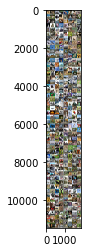

 bird  deer plane  deer  ship   cat   dog  frog plane  deer   car   cat  bird   dog   cat   dog   dog   cat  ship   car   cat plane horse  ship horse  frog  frog  ship  bird   cat  frog   car   cat   car plane truck   car  frog  deer   cat   dog truck truck  ship  ship  bird  deer   dog  ship horse   cat   car  ship   dog   cat  deer plane plane  ship truck   dog  frog  deer   cat   car plane  bird   car truck  frog  deer  deer   cat   cat  deer horse plane   car  deer  deer horse horse  deer   car  bird truck  frog  deer  frog plane  ship   cat truck  ship  ship plane  ship   car   dog plane  deer  frog  bird   cat  bird horse plane plane   car horse truck   dog  frog   dog  frog  deer  frog   car truck  frog  deer  deer truck  frog truck   cat  ship   dog  frog plane truck  ship  ship plane  ship  deer plane plane  frog   car truck  deer  ship  ship  deer  deer  bird  ship  deer   dog  frog horse   dog horse plane   car   car   cat  deer truck  deer  bird  ship   cat   dog horse truc

In [4]:
"""Let's make sure the images are resized properly"""
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# STEP 2: Define an instance of our model

In this case, we will be using the model architecture described in the following paper: https://arxiv.org/pdf/1510.07391.pdf

The model is implemented in a class called `ShapeColorClassifier`, with an optional constructor parameter for specifying a higher or lower number of outputs. Now, the model architecture was designed to identify the color of cars (and soon AUVSI SUAS objects). Until we get a dataset of AUVSI SUAS objects, we will use the model to classify objects described by the CIFAR-10 dataset.

Here, we define a `ShapeColorClassifier` instance, located in `shape_color_classifier_model.py`, with an output of 10 features, being the 10 classes of CIFAR-10.
From there, we push the model to the device assigned at the beginning of the notebook, as the model and data tensors need to be on the same device during training and inference.

In [5]:
# Because there are 10 classes in CIFAR-10, we will define 10 classes for model
# In this case, the classifier will be used to classify the 10 classes of CIFAR-10, not colors.
net = ShapeColorClassifier(num_colors=10)

# PyTorch tensors contain a function called to().
# This function tells PyTorch to move the tensor to whatever device is assigned at the beginning.
net.to(device=device)

ShapeColorClassifier(
  (top_conv1): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (top_conv2_p1): Sequential(
    (0): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (top_conv2_p2): Sequential(
    (0): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (top_conv3): Sequential(
    (0): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1),

# STEP 3: Define Loss Function and Optimizer

A **loss function** is a function that describes the **"loss"** a model incurs in a single training step. When it comes to classification, "loss" is computed based on how many **labels** (or answers) the model predicted correctly when compared against the **true labels** (or right answers).

An **optimizer** is a function that takes the loss of a function and computes a new set of weights in hopes that it minimizes the loss. Essentially, the optimizer trys to push the model towards the right solution. When defining the optimizer instance, we can specify several parameters, with the most important being the **learning rate**, which specifies how fast the optimizer can change the weights. A high learning rate means that the model's weights change in big intervals, which a low learning rate means that the model's weights change in smaller intervals.


According to the report on the model architecture we are using, the loss function we will be using is called **Cross Entropy Loss** and the optimizer will be **Stochastic Gradient Descent (SGD)**.

In [6]:
"""STEP 3: Define Loss Function and Optimizer"""
# CrossEntropyLoss computes the loss between predicted label and true label.
criterion = nn.CrossEntropyLoss()

# According to model's report, stochastic gradient descent (SGD) was used as the loss function.
# The loss function has a weight decay and momentum applied to it.
# Momentum = 0.9
# Weight Decay = 0.0005
# Learning rate = 0.01 -> Reduced by factor of 10 at multiple iterations of 50,000 with maximum iteration of 200,000
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# STEP 4: Training the Model

Here we have the training loop we will use to train the model. This consists of an inner loop and an outer loop.

Before executing the loop, we specify the number of **epochs** we want the model to train for. An **epoch** represents one, single pass of ALL images in the training dataset, which is taken care of in the inner loop.

In the INNER loop, one training step consists of the following procedures:
1. Retrieve a batch of images (along with their true labels) from the training `Dataloader` object, and move them to the device specified at the beginning of the notebook. Remember, the model and data tensors MUST be on the same device during training and inference.
2. **VERY IMPORTANT:** Zero the parameter gradients. In order for optimizer to calculate the new set of model weights, it requires a mathematical thing known as "gradients." PyTorch model instances keep track of these gradients, but they must be resetted before every training step because they accumulate.
3. Pass the training images through the network and record the predicted labels. From there, the predicted labels and the true labels are passed into the loss function to calculate the loss, which the optimizer then uses to calculate new model weights.

After completing the three main steps listed above in the INNER loop, we could do other things in the INNER loop, such as:
- Creating a training "checkpoint" every few Epochs to save our training progress in case it stops for some reason.
- Record model metrics such as loss and accuracy.

In [7]:
"""STEP 4: Train the network"""
NUM_EPOCH = 100

for epoch in range(NUM_EPOCH):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        
        # Get training images and their corresponding labels
        inputs, labels = data
        inputs, labels = inputs.to(device=device), labels.to(device=device)

        # IMPORTANT: Zero the parameter gradients
        optimizer.zero_grad()

        # Pass images through network, calculate the loss, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print useful statistics every 100 mini-batches
        running_loss += loss.item()
        if i % 50 == 49: # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
    
    print('EPOCH ' + str(epoch) + ': ' + str(running_loss))

print('Finished Training')

c:\Users\xeric\Documents\UAS @ UCLA\AUVSI SUAS 2021-2022\auvsi-suas-2021\ml\shape_color_classification\shape_color_classifier_model.py:155: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classification = F.softmax(classification)


[1,    50] loss: 2.302
[1,   100] loss: 2.301
EPOCH 0: 57.475594997406006
[2,    50] loss: 2.288
[2,   100] loss: 2.272
EPOCH 1: 56.57747197151184
[3,    50] loss: 2.231
[3,   100] loss: 2.160
EPOCH 2: 53.49499011039734
[4,    50] loss: 2.127
[4,   100] loss: 2.103
EPOCH 3: 52.45402717590332
[5,    50] loss: 2.080
[5,   100] loss: 2.078
EPOCH 4: 51.679540157318115
[6,    50] loss: 2.052
[6,   100] loss: 2.045
EPOCH 5: 51.36341643333435
[7,    50] loss: 2.031
[7,   100] loss: 2.029
EPOCH 6: 50.63702702522278
[8,    50] loss: 2.020
[8,   100] loss: 2.009
EPOCH 7: 50.16161286830902
[9,    50] loss: 2.001
[9,   100] loss: 2.000
EPOCH 8: 49.60573327541351
[10,    50] loss: 1.980
[10,   100] loss: 1.986
EPOCH 9: 49.616687417030334
[11,    50] loss: 1.973
[11,   100] loss: 1.967
EPOCH 10: 49.31928026676178
[12,    50] loss: 1.960
[12,   100] loss: 1.955
EPOCH 11: 48.85770606994629
[13,    50] loss: 1.949
[13,   100] loss: 1.947
EPOCH 12: 48.83442664146423
[14,    50] loss: 1.935
[14,   100] l

# STEP 5: Save Trained Model

Once we trained our model to our satisfaction, we need to save it in order for it to be used in inference. We can easily do this by using the `torch.save()` function as follows.

In [12]:
import time
from platform import system

"""Save the model's training progress"""
fname = 'shape_color_classifier_checkpoint.pt'
torch.save(net.state_dict(), fname)

# Running Inference on a PyTorch Model

Now that we have a trained model, we can run inference on it. **Inference** means calculating the output of the model based on the input data; in our case, we are figuring out which class the object in our input image belongs too.

Before running inference, we need to switch the model from a so-called "training mode" to "inference mode." This is done by using `eval()`, which exists in every model instance.
- If you want to go back to "training mode," use `train()`

Here, we will be passing a single image from a batch of images we retrieved through out model and printing out the predicted label.

You may notice that our predicted label is a list of floating point numbers. This is because our model calculates the *probability* of the type of object in the input image; this is due to **softmax function** applied at the end of the model's architecture. In practice, we would take the highest probability to be our answer.

True Labels: tensor(3, device='cuda:0')
Predicted Labels: tensor([[4.8282e-05, 5.3531e-05, 3.3448e-04, 7.6949e-01, 1.4448e-05, 2.2921e-01,
         2.9180e-05, 5.7326e-04, 1.2024e-04, 1.2672e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


c:\Users\xeric\Documents\UAS @ UCLA\AUVSI SUAS 2021-2022\auvsi-suas-2021\ml\shape_color_classification\shape_color_classifier_model.py:155: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classification = F.softmax(classification)


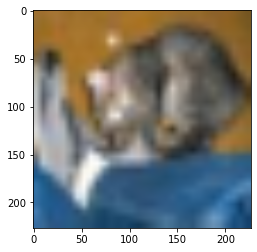

In [20]:
# Switches the model from "training mode" to "inference mode"
net.eval()

# Retrieve a batch of images from the test loader
test_inputs, test_labels = next(iter(testloader))
test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

# From the batch of images, retrieve a single image to run inference on.
input = test_inputs[0:1, :, :, :]
true_label = test_labels[0]

# Run inference, and retrieve the label from the model.
predicted_label = net(input)


print('True Labels: ' + str(true_label))
print('Predicted Labels: ' + str(predicted_label))

input = input.to('cpu')
imshow(torchvision.utils.make_grid(input))

# Exporting PyTorch to ONNX

**ONNX** stands for "Open Neural Network Exchange", and it is a file format that allows ML/AI developers to develop models across the wide variety of ML frameworks out there, such as TensorFlow, PyTorch, Caffe, and more!

As mentioned, ONNX allows us to deploy models written in PyTorch to other ML frameworks like TensorFlow. **But most importantly, ONNX is the format Intel's Neural Compute Stick 2 uses to run model inference.**

The following code was taken off the following Intel OpenVINO tutorial: https://docs.openvino.ai/latest/openvino_docs_MO_DG_prepare_model_convert_model_Convert_Model_From_PyTorch.html#export-to-onnx

In [22]:
import torch

# Instantiate your model.
model = ShapeColorClassifier(num_colors=10)     # num_colors = 10 due to the 10 classes in CIFAR-10

# Load the model weights from training step.
model.load_state_dict(torch.load('./shape_color_classifier_checkpoint.pt'))

# Evaluate the model to switch some operations from training mode to inference.
model.eval()

# Create dummy input for the model. It will be used to run the model inside export function.
# In this case, model input is (227 x 227) RGB images.
dummy_input = torch.randn(1, 3, 227, 227)

# Call the export function.
torch.onnx.export(model, (dummy_input, ), 'shape_color_classifier_model.onnx', opset_version=11)    # Set opset_version to <= 11 to ensure complete conversion.

c:\Users\xeric\Documents\UAS @ UCLA\AUVSI SUAS 2021-2022\auvsi-suas-2021\ml\shape_color_classification\shape_color_classifier_model.py:155: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classification = F.softmax(classification)
